# Прогноз количества сделок на рынке недвижимости  

In [368]:
import pandas as pd
import numpy as np
from datetime import timedelta

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.compose import ColumnTransformer
from catboost import CatBoostRegressor

pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(rc={'figure.figsize':(15,7)},style="whitegrid")
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

Подгрузка датасета (так как в аналитике использовался усеченый датасет, то и для построения прогнозов используется тот же временной ряд, чтобы не нарушать семантику анализа).

In [371]:
data_deal = r"C:\Users\Mishe\Downloads\massive.xlsx"
df = pd.read_excel(data_deal, parse_dates=['Месяц и год даты договора'])

In [373]:
df.head()

,ID проекта,ID корпуса,Проект,Локация,Город,Округ,Район,Адрес корпуса,Класс,Конструктив здания,Девелопер,Застройщик,Стадия строительной готовности на дату договора,Старт продаж,Заявленный срок ввода в эксплуатацию,Дата договора,Месяц и год даты договора,Квартал и год договора,Год договора,Дата регистрации,Месяц и год даты регистрации,Квартал и год регистрации,Год регистрации,Тип сделки,ID лота,Тип объекта,Секция,Этаж,Количество комнат,"Количество комнат в прайс-листе, типология bnmap.pro",Универсальная комнатность,Номер объекта в составе ЕГРН,Номер объекта в ПД,Площадь согласно ЕГРН,Площадь согласно ПД,Цена за кв. метр,Метод определения цены,Расчетный бюджет объекта,Включение скидок/акций в ценообразование,Скидки по дате договора,Отделка по корпусу,Цена отделки,Тип продавца,Тип покупателя,Кол-во покупателей,Код покупателя,Тип ипотеки,Залогодержатель/Банк,Кол-во месяцев обременения,Участие объекта в оптовой сделке,Дата первого появления в экспозиции,"Срок в экспозиции до момента сделки, дней",Цена 1 кв.м первого появления в экспозиции,Бюджет покупки первого появления в экспозиции,Рост цены за 1 кв.м за период экспонирования,Рост бюджета покупки за период экспонирования,Дата актуальности данных,История участия объекта в сделках (ПДн),Дата регистрации материнской сделки,Дата договора материнской сделки,Количество повторных сделок
0,8343b893da2aba6cb6e653a6b2758707,5406d8908e2e8540565788e820118582,Мичуринский парк,Москва,Москва,ЗАО,Очаково-Матвеевское,"Озёрная ул., д. 44, к. 2.4",Комфорт,Монолит-панель-блоки,ПИК,Озёрная 44,Монтажные и отделочные работы,2022-06-06,2024-06-30,2023-01-02,2023-01-01,1кв. 2023,2023,2023-01-26,2023-01-01,1кв. 2023,2023,Договор участия,23f890a85aaa1833d10bb3589deb6935,квартира,NaN,26,1,1,1,337,337,43.60,43.60,260640.0,Прайс точное совпадение,11363904.0,со скидкой,Скидка 15-22% при 100% оплате / ипотеке (без и...,Предчистовая,NaN,ЮЛ,ФЛ,1,7e269d39127ec64a79da53058e62b9,Нет,NaN,NaN,Нет,2022-06-07,209,"246527,98","10748620,00","5,7%","5,7%",2024-03-01,2023-01-02 Договор участия 9a874f9791e5f2680af...,2023-01-26,2023-01-02 00:00:00,0
1,a7e9392c9f33a09aafe185a03160adf6,dbb9905ef81eaa4d8b94a1392153346f,Михайловский парк,Москва,Москва,ЮВАО,Рязанский,"2-я Институтская ул., к. 1",Комфорт,Монолит-панель,ПИК / Capital Group,Скайтауэр Груп,Монтажные и отделочные работы,2021-10-12,2024-06-30,2023-01-03,2023-01-01,1кв. 2023,2023,2023-01-16,2023-01-01,1кв. 2023,2023,Договор участия,da3c74919dbcc95c1b22de5f9a2bb7fc,квартира,2,18,1,ст,ст,698,698,24.04,24.04,273332.0,Прайс точное совпадение,6570901.0,со скидкой,Скидка 17-24% при 100% оплате наличными / семе...,Чистовая,NaN,ЮЛ,ФЛ,3,fc02f41289ec507e2c30aff2e7a563,Нет,NaN,NaN,Нет,2022-08-19,137,"276829,99","6654993,00","-1,3%","-1,3%",2024-01-31,2019-05-02 Договор уступки 8720018455c063d043a...,2019-05-22,2019-05-02 00:00:00,1
2,f84c01186fb55b637c38ada30f678061,76d373df5e11e5b8ffa9a3c5c6c06506,Академика Павлова,Москва,Москва,ЗАО,Кунцево,"Академика Павлова ул., к. 56",Комфорт,Монолит-панель,ПИК,СЗ КУНЦЕВО-ИНВЕСТ,Монтажные и отделочные работы,2021-07-22,2024-03-31,2023-01-03,2023-01-01,1кв. 2023,2023,2023-01-19,2023-01-01,1кв. 2023,2023,Договор участия,e254fbea1eda8596a2648d017aff2b7d,квартира,3,5,3,3,3,614,614,78.50,78.50,286650.0,Прайс точное совпадение,22502025.0,со скидкой,Скидка 15-22% при 100% оплате наличными. Спец....,Чистовая,NaN,ЮЛ,ФЛ,2,7e269d39127ec64a79da53058e62b9,Нет,NaN,NaN,Нет,2022-03-01,308,"321800,00","25261300,00","-10,9%","-10,9%",2024-01-09,2023-01-03 Договор участия ef1f8f86505acd8a4ce...,2023-01-19,2023-01-03 00:00:00,0
3,49a3b5aa0c30b65c7de9faeadb5cb803,3a035c76c3224b5bd6b65d0225f60bea,Второй Нагатинский,Москва,Москва,ЮАО,Нагатино-Садовники,"2-й Нагатинский пр-д, вл. 2/2, к. 2",Комфорт,Монолит-панель,ПИК / Capital Group,СЗ АК 16,Монтажные и отделочные работы,2020-10-22,2023-03-31,2023-01-04,2023-01-01,1кв. 2023,2023,2023-01-19,2023-01-01,1кв. 2023,2023,Договор участия,5901d7648ff08aeb30d2ed8358b50231,квартира,2,12,1,1,1,544,544,32.40,41.60,318260.0,Анали

На величину спроса больше всего влияют такие факторы как количество комнат в квартире, наличие отделки, класс недвижимости и расположение ЖК. Уникальными строками в датасете выступают только ID лота. Временной ряд по месяцу договора - в датасете уже присутствует преобразование дат для будущей группировки.

In [376]:
date_col = "Месяц и год даты договора"
id_col = "ID лота"
seg_cols = ["Район", "Класс"]

room_col = "Универсальная комнатность"
fin_col = "Отделка по корпусу"

На данном этапе зачищаем пустые значения в датах и просто переименовываем столбец для дальнейшей работы с ним

In [379]:
df = df.copy()
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df = df.dropna(subset=[date_col])

df.rename(columns={'Месяц и год даты договора': 'month'}, inplace=True)
# df = df.sort_values("month")

На данном этапе в целом вычисляется сводная таблица по расчету общего количества сделок в соответствии с месяцем

In [382]:
#y:сделки в месяц по сегменту
y_seg = (
    df.groupby(["month"] + seg_cols)[id_col]
      .nunique()
      .rename("y")
      .to_frame()
)

#н данном этапе вычисляется сводная таблица по месяцам и слиянию факторов района и класса
all_months = pd.date_range(df["month"].min(), df["month"].max(), freq="MS")
all_segs = df[seg_cols].drop_duplicates()

full_index = (
    all_segs.assign(_k=1)
    .merge(pd.DataFrame({"month": all_months, "_k": 1}), on="_k")
    .drop(columns="_k")
    .set_index(["month"] + seg_cols)
    .sort_index()
)

panel = full_index.join(y_seg, how="left").fillna({"y": 0}).reset_index()

In [384]:
#создание сводных таблиц внутри сегмента квартир -комнатность и отделка 
def add_pivot_counts(panel, df, col_name, prefix):
    tmp = (
        df.groupby(["month"] + seg_cols + [col_name])[id_col]
          .nunique()
          .rename("cnt")
          .reset_index()
          .pivot_table(index=["month"] + seg_cols, columns=col_name, values="cnt", fill_value=0)
    )
    tmp.columns = [f"{prefix}__{str(c)}" for c in tmp.columns]
    tmp = tmp.reindex(full_index.index, fill_value=0)
    out = panel.set_index(["month"] + seg_cols).join(tmp, how="left").fillna(0).reset_index()
    return out

panel = add_pivot_counts(panel, df, room_col, "room")
panel = add_pivot_counts(panel, df, fin_col, "fin")

#сезонность
panel["month_num"] = panel["month"].dt.month

На данном этапе происходит слияние сводных таблиц с внешними признаками (район+класс) с внутренними признаками (отделка+комнатность).

In [387]:
panel = panel.sort_values(seg_cols + ["month"]).reset_index(drop=True)

dist_cols = [c for c in panel.columns if c.startswith("room__") or c.startswith("fin__")]
g = panel.groupby(seg_cols, sort=False)

panel["y_lag1"] = g["y"].shift(1)
panel["y_lag2"] = g["y"].shift(2)

#расчет скользящего среднего значения и сдвиг на 1 месяц, чтобы не было утечки
panel["y_roll3_mean"] = g["y"].transform(
    lambda s: s.shift(1).rolling(window=3, min_periods=3).mean()
)

#лаг распределений
panel[dist_cols] = g[dist_cols].shift(1)

panel = panel.dropna().reset_index(drop=True)

y = panel["y"]
cat_features = seg_cols
num_features = ["month_num", "y_lag1", "y_lag2", "y_roll3_mean"] + dist_cols
X = panel[cat_features + num_features]

In [389]:
months = np.array(sorted(panel["month"].unique()))
n_splits = 3
fold_sizes = np.full(n_splits, len(months) // n_splits, dtype=int)
fold_sizes[:len(months) % n_splits] +=1

На данном этапе учится модель на подготовленных данных: out-of-fold прогнозы (т.е. прогноз для каждого месяца считается моделью, обученной только на прошлых месяцах)

In [392]:
oof_pred = pd.Series(index=panel.index, dtype=float)

maes = []
start = 0
model = CatBoostRegressor(random_state=42, cat_features=cat_features, verbose=False)

for i, fs in enumerate(fold_sizes, 1):
    test_months = months[start:start+fs]
    train_months = months[:start]
    start += fs

    if len(train_months) == 0:
        continue

    tr_idx = panel["month"].isin(train_months)
    te_idx = panel["month"].isin(test_months)

    X_tr, y_tr = X.loc[tr_idx], y.loc[tr_idx]
    X_te, y_te = X.loc[te_idx], y.loc[te_idx]

    model.fit(X_tr, y_tr)
    pred = model.predict(X_te)
    pred = np.clip(pred, 0, None)

    oof_pred.loc[te_idx] = pred

    mae = mean_absolute_error(y_te, pred)
    maes.append(mae)
    print(f"Fold {i}: test months {test_months[0]}..{test_months[-1]}, MAE={mae:.3f}")

print("MAE mean:", float(np.mean(maes)))

Fold 2: test months 2023-10-01 00:00:00..2024-03-01 00:00:00, MAE=22.056
Fold 3: test months 2024-04-01 00:00:00..2024-09-01 00:00:00, MAE=19.247
MAE mean: 20.65143253249969


In [394]:
plot_df = panel.copy()
plot_df["y_true"] = y.values if isinstance(y, pd.Series) else y
plot_df["y_pred"] = oof_pred

График сравнения реальных величин, baseline (скользящее среднее) и модели машинного обучения (catboost)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


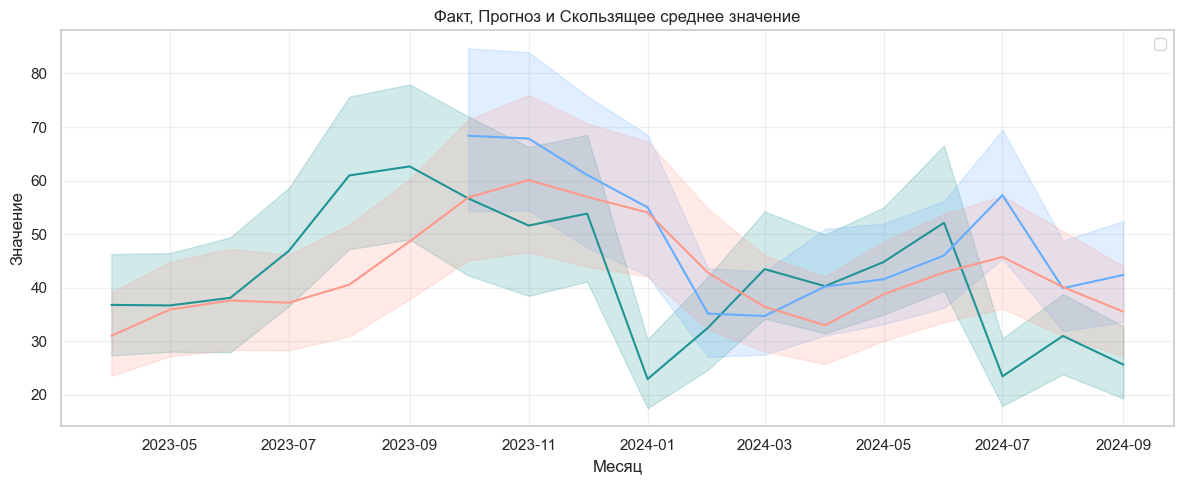

In [397]:
df = plot_df.sort_values("month")

plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x='month', y='y_true', color='#209494')
sns.lineplot(data=df, x='month', y='y_pred', color='#65ADFF')
sns.lineplot(data=df, x='month', y='y_roll3_mean', color='#FF998A')

plt.title("Факт, Прогноз и Скользящее среднее значение")
plt.xlabel("Месяц")
plt.ylabel("Значение")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [399]:
df_eval = plot_df[plot_df['month'] >= '2023-10-01']

mse_catboost = mean_squared_error(df_eval['y_true'], df_eval['y_pred'])
mse_roll_m = mean_squared_error(df_eval['y_true'], df_eval['y_roll3_mean'])
mae_catboost = mean_absolute_error(df_eval['y_true'], df_eval['y_pred'])
mae_roll_m = mean_absolute_error(df_eval['y_true'], df_eval['y_roll3_mean'])

print(f'MAE for catboost: {mae_catboost}')
print(f'MSE for catboost: {mse_catboost}')
print(f'MAE for rolling mean : {mae_roll_m}')
print(f'MSE for rolling mean : {mse_roll_m}')

MAE for catboost: 20.651432532499683
MSE for catboost: 1501.520033711021
MAE for rolling mean : 18.304125816993462
MSE for rolling mean : 1287.447644335512


По итогу мы можем наблюдать, что консервативные статистические методы на малой выборке данных более эффективны, чем модели машинного обучения.